In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches


import glob


import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Import Data

### Load in GEOS Chem Runs made from File Creation Notebook, Load in HEMCO Emissions Files

In [2]:
ds = xr.open_zarr('./nonuc_normal_GC')

In [3]:
ds_emis = xr.open_zarr('./emissions_HEMCO')

### Define variables and lists

In [4]:
#define Lat and Lon of the nested grid US

levels_dict = {'PM25':np.arange(0., 40., .5), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 40., 1.),
               'dif':np.arange(-1., 1.01, .01), 'regional_dif':np.arange(-1.5, 1.51, .01), 'regional_dif_tight':np.arange(-.3, .31, .01),
              'percent_dif_full':np.arange(-100, 101, 1), 'percent_dif_tight':np.arange(-10,10.1,.1)}


species_dict = {'PM25':'PM2.5 - Local Conditions', 'SO2':'Sulfur Dioxide', 'NO2':'Nitrogen dioxide (NO2)', 'O3':'Ozone', 'NOx':'Nitrogen Oxides (NO2+NO)'}

model_names = ds['model_name'].values

cmap_dif = 'BrBG_r'
cmap_conc = 'pink_r'
cmap_discrete = cm.get_cmap('Paired', 3) 

cities_dict = {'Bismarck':[46.8083, -100.7837],
               'Charlotte':[35.2271, -80.8431],
               'Los Angeles': [34.0522, -118.2437],
               'Memphis':[35.1495, -90.0490],
               'Pittsburgh':[40.4406, -79.9959],
               'Portland': [45.5051, -122.6750],
              'San Francisco':[37.775,-122.4183],
              'Salt Lake City':[40.7608, -111.8910],
              'Sacramento':[38.5816, -121.4944]}

# Plots

## US, concentrations

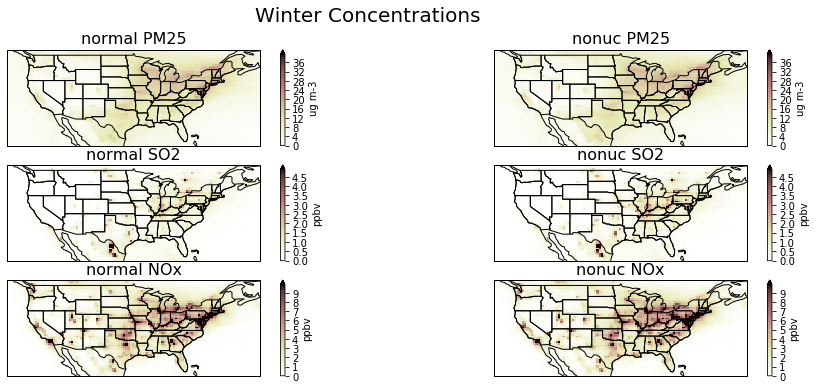

In [83]:
plotting.concentration_plot_seasonal(ds = ds, species_names = ['PM25','SO2','NOx'], season = 'DJF', model_names = model_names,  cmap = cmap_conc,
                        lat_lon = utils.lat_lon_dict['US_lat_lon'], shrink_cbar = 1,
                       figsize = [16,6])
plt.suptitle('Winter Concentrations', fontsize = 20);

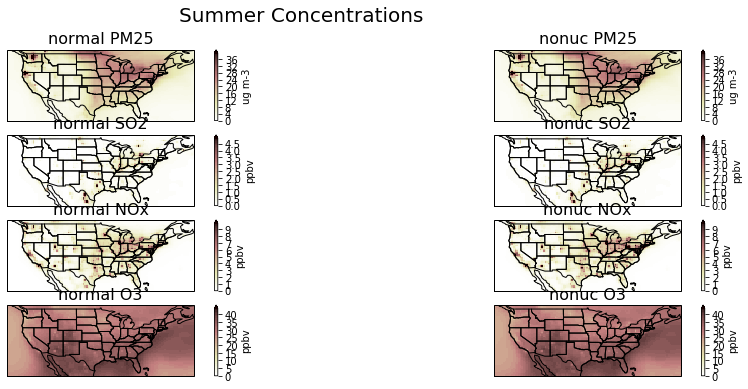

In [84]:
plotting.concentration_plot_seasonal(ds = ds, species_names = ['PM25','SO2','NOx','O3'], season = 'JJA', model_names = model_names,  cmap = cmap_conc,
                        lat_lon = utils.lat_lon_dict['US_lat_lon'], shrink_cbar = 1,
                       figsize = [16,6])
plt.suptitle('Summer Concentrations', fontsize = 20);

## US, differences

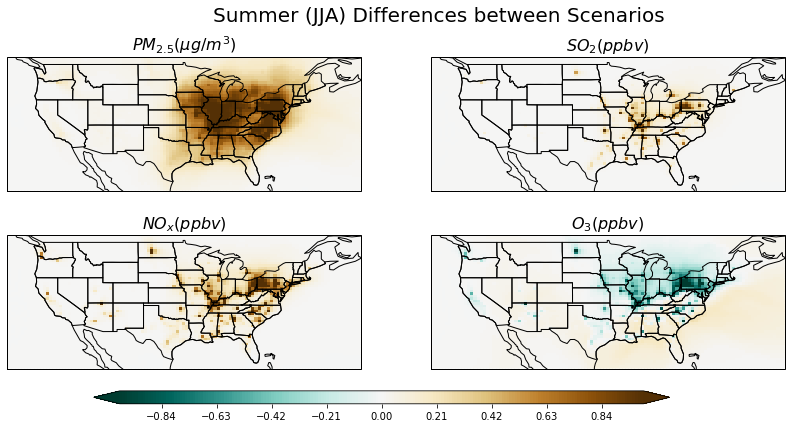

In [81]:
plotting.concentration_plot_seasonal_dif(ds = ds, season = 'JJA', species = ['PM25','SO2','NOx','O3'], cmap = cmap_dif,
                   rows = 2, columns = 2, levels = levels_dict['dif'], lat_lon = utils.lat_lon_dict['US_lat_lon'],
                   figsize = [16,6], extension = 'both')

plt.suptitle(f'Summer (JJA) Differences between Scenarios', fontsize = 20);
plt.savefig('./Figures/summer_national_dif.png', bbox_inches = 'tight', dpi = 150)

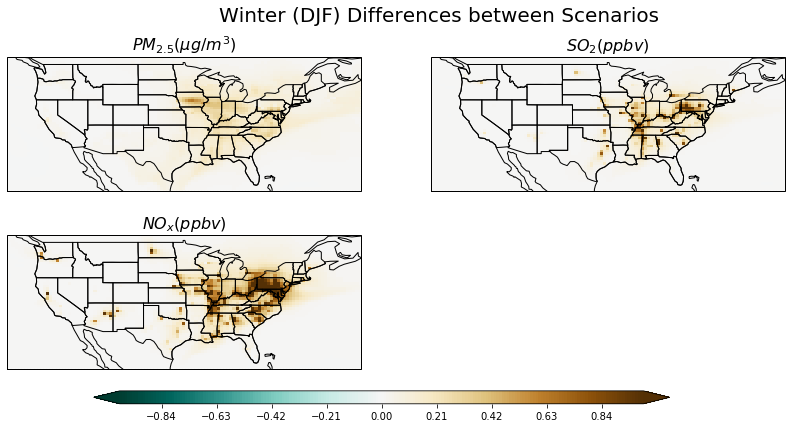

In [82]:
plotting.concentration_plot_seasonal_dif(ds = ds, season = 'DJF', species = ['PM25','SO2','NOx'], cmap = cmap_dif,
                   rows = 2, columns = 2, levels = levels_dict['dif'], lat_lon = utils.lat_lon_dict['US_lat_lon'],
                   figsize = [16,6], extension = 'both')
plt.suptitle(f'Winter (DJF) Differences between Scenarios', fontsize = 20);
plt.savefig('./Figures/winter_national_dif.png', bbox_inches = 'tight', dpi = 150)

## US, CH2O/NO2 Ratio and Ozone

Using the FNR ratio from Jin et al. 2017 (Evaluating a Space-Based Indicator of Surface Ozone-NOx-
VOC Sensitivity Over Midlatitude Source Regions
and Application to Decadal Trends)

<0.5 = VOC limited

0.5-0.8 = transitional

0.8> = NOx limited

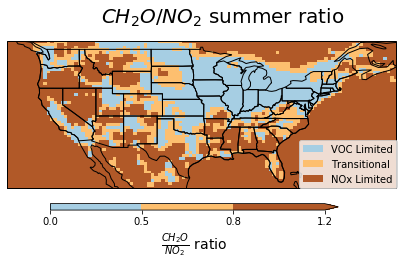

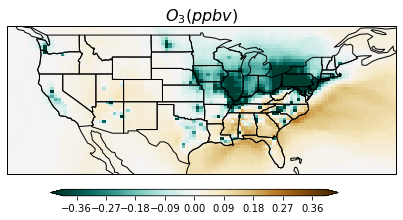

In [88]:
plotting.ratio_plot(ds = ds, season = 'JJA', species = 'CH2O_NO2', model_names = ['normal'], cmap = cmap_discrete,
                       rows = 1, columns = 1, levels = [0,.5,.8,1.2], lat_lon = utils.lat_lon_dict['US_lat_lon'], shrink_cbar = .7,
                       figsize = [8,3])
VOC_lim = mpatches.Patch(facecolor = cmap_discrete.colors[0], label = 'VOC Limited')
trans = mpatches.Patch(facecolor = cmap_discrete.colors[1], label = 'Transitional')
NOX_lim = mpatches.Patch(facecolor = cmap_discrete.colors[2], label = 'NOx Limited')
plt.legend(handles = [VOC_lim,trans,NOX_lim], loc='upper right', bbox_to_anchor=(1.22, 11.52));
plt.title('')
plt.suptitle(r'$CH_2O/NO_2$ summer ratio', fontsize = 20, y = 1);
plt.savefig('./Figures/summer_regime_national_ratio.png', bbox_inches = 'tight', dpi = 150)

plotting.concentration_plot_seasonal_dif(ds = ds, season = 'JJA', species = ['O3'], cmap = cmap_dif,
                       rows = 1, columns = 1, levels = np.arange(-.4,.41,.01), lat_lon = utils.lat_lon_dict['US_lat_lon'],
                       figsize = [8,3], 
                        extension = 'both')
plt.title('');

plt.savefig('./Figures/summer_regime_national_ozone.png', bbox_inches = 'tight', dpi = 150)

## US, emissions

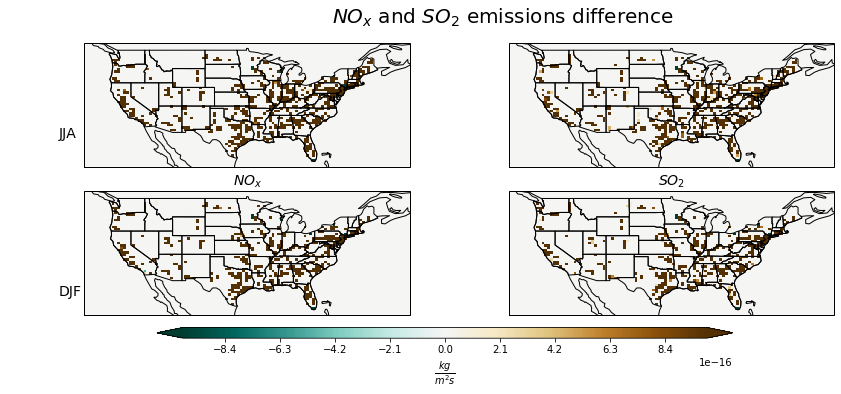

In [135]:
plotting.plot_emissions_dif(ds_emis.sel(model_name = 'nonuc'), 
                            ds_emis.sel(model_name = 'normal'), 
                            emissions = ['EmisNOx_Anthro', 'EmisSO2_Anthro'], seasons = ['JJA','DJF'], 
                            levels = np.arange(-1e-15,1.01e-15,1e-17), 
                            lat_lon = utils.lat_lon_dict['US_lat_lon'],
                           figsize = [16,5])
plt.suptitle(r'$NO_x$ and $SO_2$ emissions differences', fontsize = 20, );
plt.savefig('./Figures/summer_nox_emissions.png', bbox_inches = 'tight', dpi = 150);

# Calculate numerical differences between each scenario

In [55]:
season = 'DJF'

In [56]:
print(f'National percent change in PM2.5 in {season} ' + 
      str(ds['percent_dif_PM25'].groupby('time.season').mean().sel(season = season).mean(dim = ['lat','lon']).values.item()))
print(f'Max percent change in PM2.5 overall ' + 
      str(ds['percent_dif_PM25'].values.max()))

print(f'National change in PM2.5 in {season} ' + 
      str(ds['dif_PM25'].groupby('time.season').mean().sel(season = season).mean(dim = ['lat','lon']).values.item()))
print(f'Max change in PM2.5 overall ' + 
      str(ds['dif_PM25'].values.max()))

National percent change in PM2.5 in DJF 0.2391858845949173
Max percent change in PM2.5 overall 40.46565
National change in PM2.5 in DJF 0.01752789318561554
Max change in PM2.5 overall 10.776249


In [57]:
print('max difference in PM '+ str(ds['dif_PM25'].max().values) + ' and min ' + str(ds['dif_PM25'].min().values))
print('max difference in O3 '+ str(ds['dif_O3'].max().values) + ' and min ' + str(ds['dif_O3'].min().values))


max difference in PM 10.776249 and min -4.8197365
max difference in O3 1.7619972 and min -21.864635
